[Article >>](https://towardsdatascience.com/how-to-find-seasonality-patterns-in-time-series-c3b9f11e89c6/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import const
from read import read_data
from graphs import plot_data, plot_data_with_shadow, create_graph_frequencies, C_SCALE

In [2]:
data = read_data()
data

,date,week_day,working,out_of_home,energy,side_projects_time,read_book_time,read_crossword_time,sleep_night_time,sleep_day_time,...,macros_fat,macros_alcohol,macros_kcal,published_medium,published_linkedin,sleep_total_time,read_total_time,exercise_total_time,exercise_shoulder_raises_volume,macros_kcal_7sma
0,2024-10-01,1,True,False,3,15,0,20,420,0,...,71.0,0.0,1826,0,0,420,20,150,0.0,0.000000
1,2024-10-02,2,True,False,1,60,0,15,360,0,...,138.0,0.0,3180,0,0,360,15,20,0.0,0.000000
2,2024-10-03,3,True,False,3,60,0,15,450,0,...,118.0,0.0,2783,0,0,450,15,90,0.0,0.000000
3,2024-10-04,4,True,False,1,30,0,25,300,180,...,75.0,0.0,2146,0,0,480,25,60,0.0,0.000000
4,2024-10-05,5,False,True,3,120,0,10,360,0,...,95.0,14.0,2362,0,0,360,10,0,0.0,2459.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2025-03-27,3,True,False,1,60,0,0,480,90,...,131.7,0.0,2593,0,0,570,0,90,0.0,2333.428571
178,2025-03-28,4,True,False,3,120,5,0,390,60,...,157.5,0.0,2939,1,1,450,5,120,360.0,2373.571429
179,2025-03-29,5,False,False,2,420,5,0,480,0,...,75.6,0.0,1972,0,0,480,5,0,100.0,2432.285714
180,2025-03-30,6,False,False,2,120,0,60,450,0,...,115.0,78.0,3030,0,0,450,60,0,100.0,2401.285714


In [3]:
def calculate_fft(values):
    fft_values = np.fft.fft(values)
    frequencies = np.fft.fftfreq(len(values), 1)
    mask = frequencies > 0
    periods = 1 / (frequencies[mask])
    fft_magnitude = np.abs(fft_values) / len(fft_values)
    power_spectrum = np.abs(fft_values)**2 / len(fft_values)
    return periods, fft_values, fft_magnitude, power_spectrum, mask

### Technique (example on week day)

Was I working professionally that day?


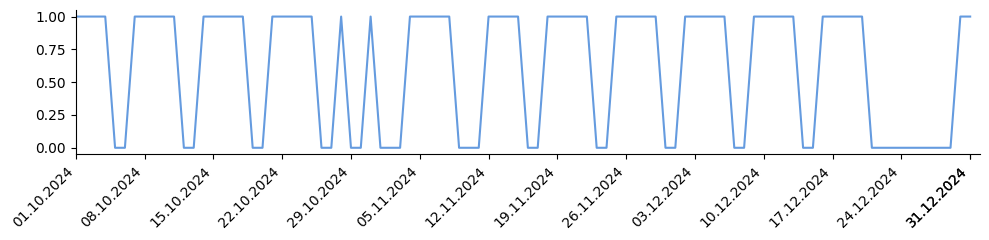

Frequencies amplitudes after Fast Fourier Transform


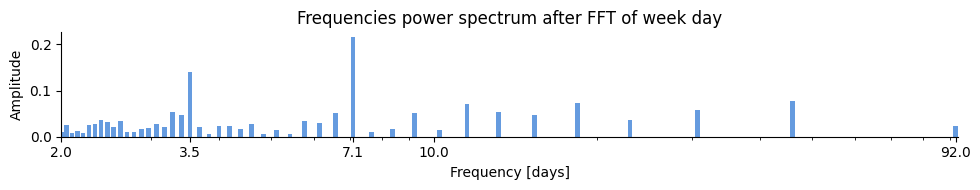

Frequencies power spectrum after Fast Fourier Transform


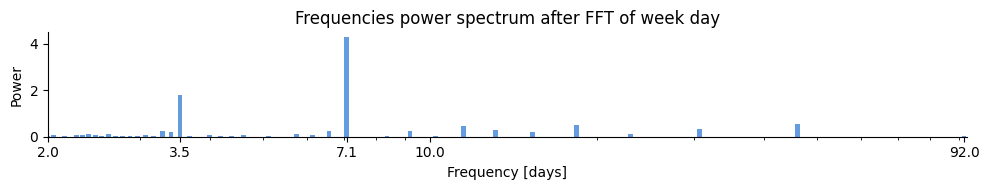

Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 1.5


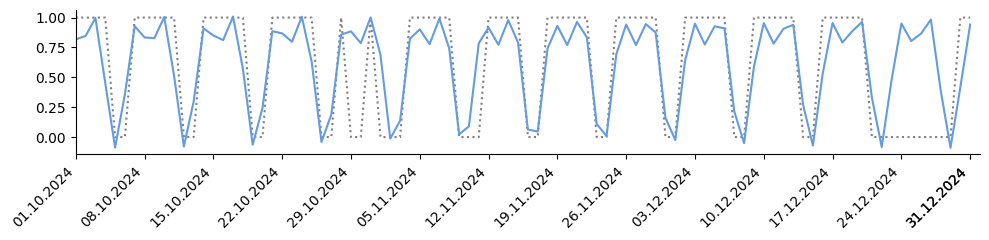

Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 0.1


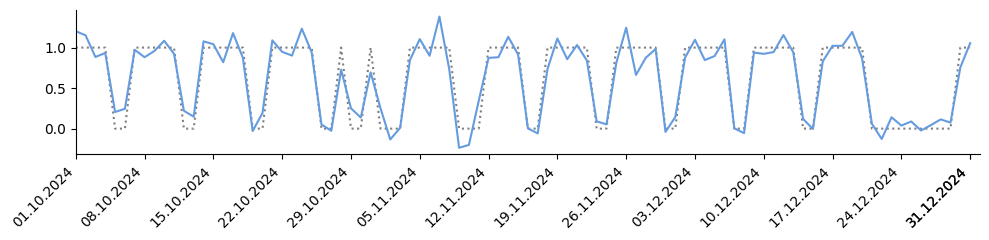

In [4]:
values = data['working'][:92]
index = data['date'][:92]
periods, fft_values, fft_magnitude, power_spectrum, mask = calculate_fft(values)
filtered_fft_low = np.where(power_spectrum >= 0.1, fft_values, 0)
reconstructed_signal_low = np.fft.ifft(filtered_fft_low).real
filtered_fft_high = np.where(power_spectrum >= 1.5, fft_values, 0)
reconstructed_signal_high = np.fft.ifft(filtered_fft_high).real

print('Was I working professionally that day?')
plot_data(values, index)
print('Frequencies amplitudes after Fast Fourier Transform')
create_graph_frequencies(fft_magnitude[mask], periods, 0.1, 0.02, 'Amplitude', 'week day')
print('Frequencies power spectrum after Fast Fourier Transform')
create_graph_frequencies(power_spectrum[mask], periods, 1.0, 0.02, 'Power', 'week day')
print('Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 1.5')
plot_data_with_shadow(reconstructed_signal_high, values, index)
print('Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 0.1')
plot_data_with_shadow(reconstructed_signal_low, values, index)


### Data

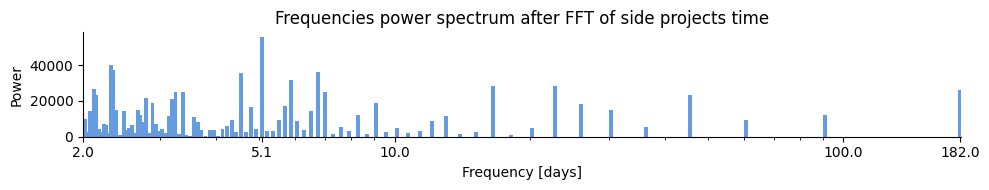

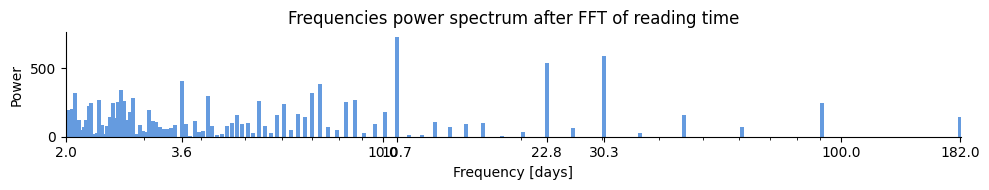

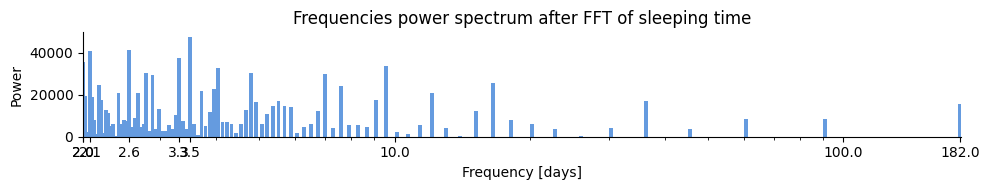

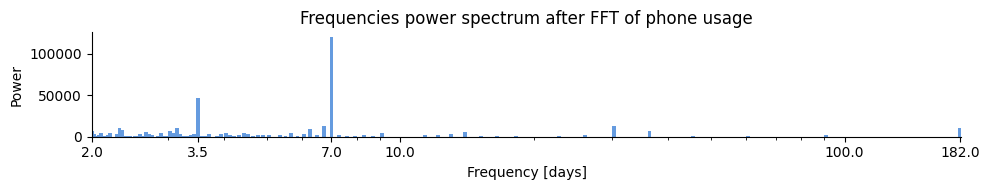

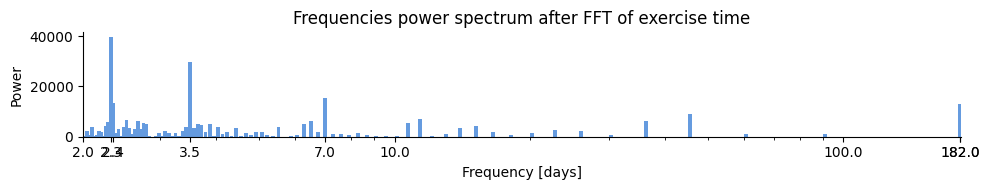

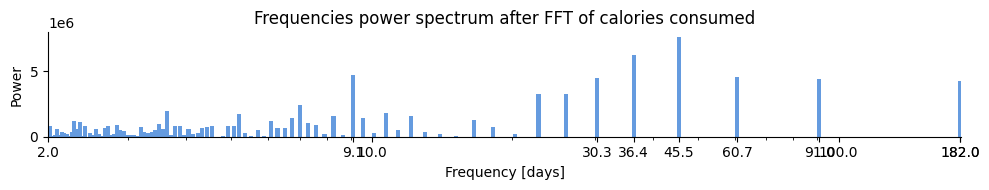

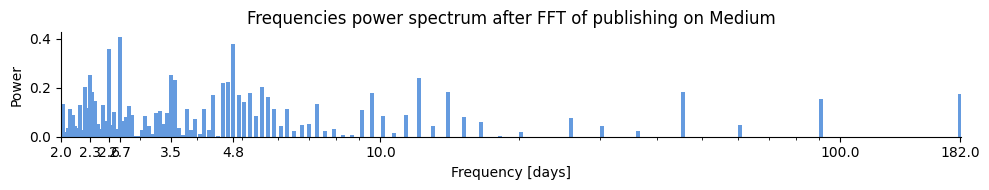

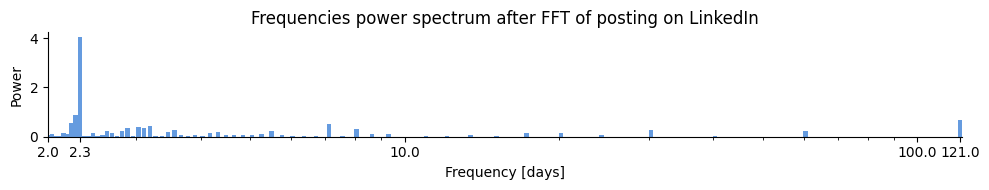

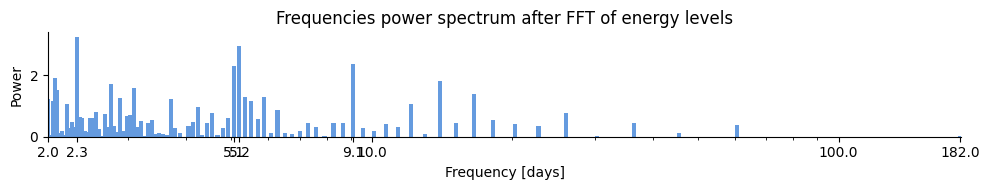

In [10]:
for col, start_index, tick_limit, bar_width, label in [
    (const.COLS_WORKING[0], 0, 45_000, 0.02, 'side projects time'),
    (const.COLS_READING[2], 0, 400, 0.02, 'reading time'),
    (const.COLS_SLEEPING[2], 0, 35_000, 0.02, 'sleeping time'),
    (const.COLS_LEISURE[0], 0, 35_000, 0.02, 'phone usage'),
    (const.COLS_EXERCISE[6], 0, 10_000, 0.02, 'exercise time'),
    (const.COLS_EATING[4], 0, 4e6, 0.02, 'calories consumed'),
    (const.COLS_PUBLISHING[0], 0, 0.25, 0.02, 'publishing on Medium'),
    (const.COLS_PUBLISHING[1], 61, 1.0, 0.02, 'posting on LinkedIn'),
    (const.COLS_OTHER[4], 0, 2.0, 0.02, 'energy levels'),
]:
    periods, _, _, power_spectrum, mask = calculate_fft(data[col][start_index:])
    create_graph_frequencies(power_spectrum[mask], periods, tick_limit, bar_width, 'Power', label)

### Energy

In [6]:
energy = data[const.COLS_OTHER[4]]
values = {}

def count_prob_after(label: str, value: int):
    low = ((energy == 1) & (energy.shift(1) == value)).sum()
    neutral = ((energy == 2) & (energy.shift(1) == value)).sum()
    high = ((energy == 3) & (energy.shift(1) == value)).sum()
    all = low + neutral + high
    print(f'After {label} energy, the next day will be: low ({low/all:.1%}), neutral ({neutral/all:.1%}), high ({high/all:.1%})')
    values[label] = {'low': low, 'neutral': neutral, 'high': high}

count_prob_after('low', 1)
count_prob_after('neutral', 2)
count_prob_after('high', 3)

df = pd.DataFrame(values)
for c in df.columns:
    df[c] = df[c].map(lambda x: x/len(energy))
display(df)

After low energy, the next day will be: low (25.6%), neutral (30.2%), high (44.2%)
After neutral energy, the next day will be: low (19.4%), neutral (43.3%), high (37.3%)
After high energy, the next day will be: low (28.2%), neutral (35.2%), high (36.6%)


,low,neutral,high
low,0.060440,0.071429,0.109890
neutral,0.071429,0.159341,0.137363
high,0.104396,0.137363,0.142857


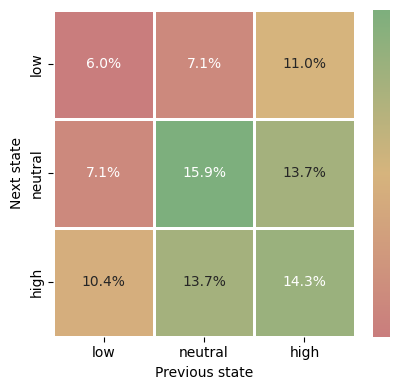

In [7]:
fig, ax = plt.subplots(figsize=(4.5, 4))
cmap = mcolors.LinearSegmentedColormap.from_list("smooth_cmap", C_SCALE)
sns.heatmap(df, ax=ax,
            annot=True, fmt=".1%",
            cmap=cmap, cbar=True, cbar_kws={'ticks': []},
            linewidths=1, linecolor='white')
ax.set_xlabel('Previous state')
ax.set_ylabel('Next state')
fig.tight_layout()
plt.show()